In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import random 
from colour import Color
from time import time
from data_mapping import get_thresh,discretize

In [6]:
#Generating an equally space grid. We make it complete, and then we remove the bottom part to make a U
x_len=10#Pick x values. must be even > 4 
y_len=10#Pick y values. must be > 4
xrange = np.arange(0,x_len);
yrange = np.arange(0,y_len);
full_grid = list(itertools.product(xrange,yrange))
#removing the center part to get the 'u maze' look
xs_rem = [4,5]#[8,9,10,11,12]
ys_rem = [0,1,2,3,4]#[0,1,2,3,4,5,6,7,8,9]
remove = list(itertools.product(xs_rem,ys_rem))
maze = []
visits = {} #A dictionary that records the states that led us here
count = 0
for x,y in full_grid:
    if (x,y) not in remove:
        maze.append((x,y))
        visits[count] = []
        count += 1

grid = pd.DataFrame(maze)
# grid['count'] = 0
# #Generating the trajectory dataset
# #We follow these assumptions: 1) We have a single random trajectory, until we cover all points in two directions 
# # With two directions we ensure that we never have a dead end, since we can 
# init_point = random.sample(maze,1)[0]
# init_point = (init_point[0],init_point[1],random.sample([-1,1],1)[0],random.sample([-1,0,1],1)[0])
# finish = False
# current_point = init_point
# trajectory = [current_point]
# max_steps = 5000
# step = 0



In [7]:
list_of_goal = [(1,1),(1,2),(1,3),(2,3)]

In [8]:
obs = pd.read_csv('data/obs.csv',usecols=[1,2])
data = obs.values
data = np.concatenate((data,list_of_goal))
thresh = get_thresh(10, data)
mapping_data = discretize(data, thresh, 10)
df = pd.DataFrame(mapping_data, columns=['x', 'y'])
timeouts = pd.read_csv('data/timeouts.csv',usecols=[1])
l = np.where(timeouts['timeouts'])[0].tolist()
l_mod = [0] + l + [max(l)+1]
# plt.scatter(x = goals['x'], y = goals['y'], c='b',alpha=0.2, s=100)
list_of_goals = df.iloc[-4:].values
df = df.iloc[0:-4]
df.drop_duplicates(keep='first', inplace=False, ignore_index=False) #Dropping duplicated cause by slow motion in the continuous space
list_of_obs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]
np.random.seed(15)
sample = np.random.random_integers(0,len(l),10)

list_of_obs = [list_of_obs[i] for i in sample]

/var/folders/18/mm5m8stx2kd7ysml0n6wxx_40000gr/T/ipykernel_83524/2757323577.py:16: DeprecationWarning: This function is deprecated. Please call randint(0, 12459 + 1) instead
  sample = np.random.random_integers(0,len(l),10)


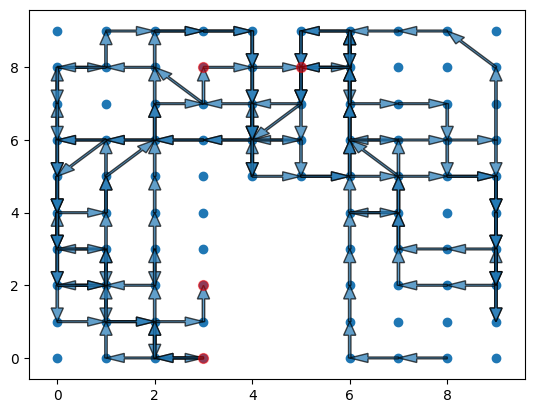

In [9]:
plt.scatter(grid[0],grid[1])
# list_of_act = [list_of_act[i] for i in sample]
# list_of_rew = [list_of_rew[i] for i in sample]

for ob in list_of_obs:
    for i in range(len(ob)-1):
        p_x,p_y = ob.iloc[i]
        n_x,n_y = ob.iloc[i+1]
        plt.arrow(p_x, p_y, n_x-p_x, n_y-p_y, width = 0.05,length_includes_head=True,head_width=0.25,alpha=0.7)
for x,y in list_of_goals:
    plt.scatter(x = x, y = y, s=50,alpha=0.5,c='r')#,s=obs['size'],c=obs['color'])


In [10]:
from collections import defaultdict
import numpy as np

class MonteCarloTreeSearchNode():
    def __init__(self,state, parent=None, parent_action=None, ancentor_path=[]):
        
        self.steps = 0

        self.ancestor_path = ancentor_path
        self.state = state
        

        self.parent = parent
        self.parent_action = parent_action
        self.possible_moves = []
        self.children = []
        self._number_of_visits = 0
        self._results = defaultdict(int)
        self._results[1] = 0
        self._results[-1] = 0
        self._untried_actions = None
        self._untried_actions = self.untried_actions()
        return
    def untried_actions(self): #returns the list of untried actions 

        self._untried_actions = self.state.get_legal_actions()
        return self._untried_actions

    def q(self): #returning difference between wins and losses
        wins = self._results[1]
        loses = self._results[-1]
        return wins - loses

    def n(self): #return number of times each node is visited
        return self._number_of_visits

    def expand(self): #expanding the current state into the next state from the action (we generate all possible children)
        
        action = self._untried_actions.pop()
        next_state = self.state.move(action,self.steps)
        child_node = MonteCarloTreeSearchNode( state=next_state, parent=self, parent_action=action)

        self.children.append(child_node)
        return child_node 

    def is_terminal_node(self): #To trigger the end of rollout and beg. of backprop
        return self.state.is_game_over()

    def rollout(self): #Simulation up until the leaf node (end of horizon)
        current_rollout_state = self.state
        
        while not current_rollout_state.is_game_over():
            self.possible_moves = current_rollout_state.get_legal_actions()
            current_rollout_state.possible_moves = self.possible_moves
            if current_rollout_state.is_game_over():
                break
            action = self.rollout_policy(self.possible_moves)
            self.steps += 1
            current_rollout_state = current_rollout_state.move(action,self.steps) 
        return current_rollout_state.game_result()

    def backpropagate(self, result): #Updating values at every point

        for (anc_x,anc_y) in self.ancestor_path:#Backprogating to the ancestors of this node
            Q[(anc_x,anc_y)]['Num_visits'] += 1
            if result == 1:
                Q[(anc_x,anc_y)]['Wins'] += 1
            else:
                Q[(anc_x,anc_y)]['Loss'] += 1
 
        #Updating Q values
        if (self.state.x,self.state.y) not in Q.keys():
            Q[(self.state.x,self.state.y)] = {'Num_visits':0,'Wins':0,'Loss':0}
        #updating visits
        Q[(self.state.x,self.state.y)]['Num_visits'] += 1
        if result == 1:
            Q[(self.state.x,self.state.y)]['Wins'] += 1
        else:
            Q[(self.state.x,self.state.y)]['Loss'] += 1
        
        #updating statistics of nodes in the path between parent and leaf
        self._number_of_visits += 1.
        self._results[result] += 1.
        if self.parent:
            self.parent.backpropagate(result)

    def is_fully_expanded(self): #When empty, then it is fully expanded
        return len(self._untried_actions) == 0

    def best_child(self, c_param=0.1): #once fully expanded, select best child out of children (exploitation, exploration)
        
        choices_weights = [(c.q() / c.n()) + c_param * np.sqrt((2 * np.log(self.n()) / c.n())) for c in self.children]
        return self.children[np.argmax(choices_weights)]

    def rollout_policy(self, possible_moves): #Random playout (selection criterion)
        # print(possible_moves)
        return possible_moves[np.random.randint(len(possible_moves))]
    
    def _tree_policy(self): #Selecting the node to perform rollout on

        current_node = self
        while not current_node.is_terminal_node():
            
            if not current_node.is_fully_expanded():
                self.steps += 1
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node
    
    def best_action(self): #Best action function, returning node corresponding to best move.
        simulation_no = 20
        
        
        for i in range(simulation_no):
            # print(f'We are in simulation {i}')
            v = self._tree_policy()

            reward = v.rollout()
            v.backpropagate(reward)
        
        return self.best_child(c_param=0)
    

class MCTS_state():
    def __init__(self,trajectory,traj_idx,position,goals,steps):
        self.steps = steps
        # print(f'This child is step number {self.steps} in the simulation')
        self.trajectory = trajectory
        self.traj_idx = traj_idx
        self.x = position[0]
        self.y = position[1]
        self.goal = goals
        self.possible_moves = None

    def get_legal_actions(self): #FUNCTION TO obtain the set of feasible actions
        '''
        Modify according to your game or
        needs. Constructs a list of all
        possible actions from current state.
        Returns a list.

        GIVEN: Current x, y position of our agent. Also we can assume we know what trajectory we're currently on

        1. Consider that we only have one trajectory. Then the action is the subsequent row given the current x,y position
           of our agent
        
        2. Consider we have intersecting trajectories. This means that all intersecting trajectories contains the exact point we're 
           currently on, since otherwise it wouldn't be intersecting. 
        
           For each trajectory we use df.loc(x, y) to check if this trajectory is intersecting. Then we have the trajectories as well as
           the index where the point is the same. Call this index i. Therefore from 1) we know that we can consider i+1 as a next legal action

           So we accumulate 1 action for each intersecting trajectory as the legal actions. We then let the montecarlo tree search
           continue the search based off this. 

           We can assume that atleast one trajectory reach any ball that can be generated in this environemnt 
        '''
        tol = 1
        possible_moves = []
        
        for cand_traj_num,cand_traj in enumerate(list_of_obs):
            # if cand_traj_num == self.trajectory:
            #     if self.traj_idx+1 in cand_traj.index: #(case 1)
            #         possible_moves.append((cand_traj_num,self.traj_idx+1))
            # else:
            # len(list_of_obs[0].head()[list_of_obs[0].head()['x']==list_of_obs[]['x'][0]])
            #x_test = cand_traj['x'] == self.x
            x_test = abs(cand_traj['x']-self.x) <= tol
            # y_test = cand_traj['y'] == self.y
            y_test = abs(cand_traj['y']-self.y) <= tol
            xy_intersect = x_test & y_test

            if sum(xy_intersect) > 0:
                cand_traj_idx = cand_traj[xy_intersect].index[-1] #We pick the last point in the trajectory that we can reach
                if cand_traj_idx+1 in cand_traj.index: #(case 1)
                    possible_moves.append((cand_traj_num,cand_traj_idx+1))
                
            # elif sum(xy_intersect) > 1:
            #     print('We might have a problem ( we pass)')
                #     pass
        self.possible_moves = possible_moves
        return possible_moves

        
        



    def is_game_over(self): #indicator for reaching leaf (end of horizon) or not
        '''
        Modify according to your game or 
        needs. It is the game over condition
        and depends on your game. Returns
        true or false
        '''
        if self.steps >= len(grid): #we are out of lookahead budget
            self.goal_reached = False
            return True
        tol = 1
        x_rad = abs(self.x - self.goal[0]) <= tol 
        y_rad = abs(self.y - self.goal[1]) <= tol
        goal_reached = x_rad and y_rad
        self.goal_reached = goal_reached
        return (goal_reached)
    
    def game_result(self): #indicator of final result
        '''
        Modify according to your game or 
        needs. Returns 1 or 0 or -1 depending
        on your state corresponding to win,
        tie or a loss.
        '''
        if self.is_game_over():
            if self.goal_reached:
                return 1.0
            else:
                # By default has to be true cause game is over and we're not in the goal state
                return -1.0
        return 0.0

    
    def move(self,action,steps):#state modification function
        '''
        Modify according to your game or 
        needs. Changes the state of your 
        board with a new value. 

        Here we update the state based off the action. 
        '''
        # display(action)
        next_state = MCTS_state(action[0],action[1],(list_of_obs[action[0]]['x'][action[1]],list_of_obs[action[0]]['y'][action[1]]),self.goal,steps)

        return next_state



In [11]:
Q = {}


In [14]:
#Training the MCTS algorithm and the Q function

sol_trajectories = []
point_rounds = 1
goal_rounds = 1

for p_round in range(point_rounds):
    traj = np.random.randint(0,len(list_of_obs))
    for g_round in range(goal_rounds):#list_of_goal[9:10]:
        goal = random.sample(list(list_of_goals),1)[0]
        ancestors_path = []
        traj_idx = list_of_obs[traj].index[0]
        initial_state = MCTS_state(traj,traj_idx,(list_of_obs[traj]['x'][traj_idx],list_of_obs[traj]['y'][traj_idx]),goal,0)
        print('The goal is ->',goal)
        print('Initial point:',initial_state.x, initial_state.y)
        root = MonteCarloTreeSearchNode(state = initial_state, ancentor_path=ancestors_path)
        selected_node = root.best_action()
        solution_traj = [{'traj':selected_node.state.trajectory,'x':selected_node.state.x,'y':selected_node.state.y}]
        ancestors_path.append((selected_node.state.x,selected_node.state.y))
        # print(selected_node.state.x, selected_node.state.y)
        count = 0
        while (not selected_node.state.is_game_over()) and (count <= len(grid)):
            currentState = MCTS_state(selected_node.state.trajectory, selected_node.state.traj_idx, (selected_node.state.x, selected_node.state.y), goal,0)
            root = MonteCarloTreeSearchNode(state = currentState, ancentor_path=ancestors_path)
            selected_node = root.best_action()
            
            solution_traj.append({'traj':selected_node.state.trajectory,'x':selected_node.state.x,'y':selected_node.state.y})
            
            ancestors_path.append((selected_node.state.x,selected_node.state.y))
            print((selected_node.state.x, selected_node.state.y))
            count += 1
        print('--------------')
        selected_node = root.best_action()
        sol_trajectories.append(solution_traj)
        print(f"Finished on state {selected_node.state.x,selected_node.state.y}, moving on")
        plt.scatter(grid[0],grid[1])
        sol_traj_df = pd.DataFrame(solution_traj)
        plt.arrow(initial_state.x, initial_state.y, sol_traj_df.iloc[0]['x']-initial_state.x, sol_traj_df.iloc[0]['y']-initial_state.y, width = 0.03,length_includes_head=True,head_width=0.25,alpha=0.5)
        for i in range(len(sol_traj_df)-1):
            p_x,p_y = sol_traj_df.iloc[i]['x'],sol_traj_df.iloc[i]['y']
            n_x,n_y = sol_traj_df.iloc[i+1]['x'],sol_traj_df.iloc[i+1]['y']
            plt.arrow(p_x, p_y, n_x-p_x, n_y-p_y, width = 0.03,length_includes_head=True,head_width=0.25,alpha=0.5)
        plt.scatter(x = initial_state.x, y = initial_state.y,lw=0.05,alpha=1,c='k')#,s=obs['size'],c=obs['color'])
        plt.scatter(x = goal[0], y = goal[1],lw=0.05,alpha=1,c='g')#,s=obs['size'],c=obs['color'])
        plt.show()
        plt.close()

####### ********** We need to add a recursion depth limit to cut wandering ************* ###########

The goal is -> [5 8]
Initial point: 9 6
(9, 2)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)
(9, 1)
(7, 2)
(7, 4)
(9, 5)
(9, 3)


KeyboardInterrupt: 

In [ ]:
from MCTS import update_Q_vals,find_possible_moves,is_game_over,game_result,comp_plot_distance

In [ ]:
Q = update_Q_vals(Q)

5 10
Reached the target


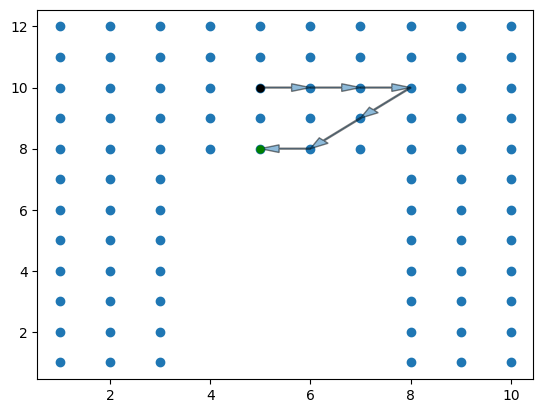

In [ ]:
#Decoding the trained Q values

#Train Q dictionary

#Get initial state
traj = np.random.randint(0,len(list_of_obs))
traj_idx = list_of_obs[traj].index[0]


curr_traj = traj
curr_traj_idx = traj_idx
curr_goal = (5,8)#ol_goals[0]#list_of_goal[9]
curr_x = list_of_obs[traj]['x'][traj_idx]
curr_y = list_of_obs[traj]['y'][traj_idx]

print(curr_x,curr_y)
is_over,goal_reached,result = False,False,0
count = 0
decoded_traj = [{'traj':curr_traj,'x':curr_x,'y':curr_y}]
count = 0
while (not is_over) and (count <= len(grid)):
    #Get next possible moves (consider some tolerance)
    possible_moves,same_traj_idx = find_possible_moves(curr_traj,curr_traj_idx,curr_x,curr_y,0,list_of_obs,Q)
    is_over,goal_reached = is_game_over(possible_moves,curr_x,curr_y,curr_goal)
    result = game_result(is_over,goal_reached)
    if goal_reached:
        print("Reached the target")
        break
        

    best_Q_vals = []
    for idx,(p_traj,p_traj_idx,p_x,p_y) in enumerate(possible_moves):
        best_Q_vals.append(Q[(p_x,p_y)]['Q_val'])
    # print('-------------')
    #Pick next move based on Q values
    if max(best_Q_vals) == min(best_Q_vals): #There is no difference in terms of moves (we stay in the current traj)
        if same_traj_idx != None:
            best_move_idx = same_traj_idx
        else:
            best_move_idx = np.random.randint(0,len(best_Q_vals))
    else:
        best_move_idx = np.argmax(best_Q_vals)
    
    #Update state
    curr_traj = possible_moves[best_move_idx][0]
    curr_traj_idx = possible_moves[best_move_idx][1]
    curr_x,curr_y = possible_moves[best_move_idx][2],possible_moves[best_move_idx][3]
    decoded_traj.append({'traj':curr_traj,'x':curr_x,'y':curr_y})
    #Repeat until goal reached or no more moves to make.
    count += 1
plt.scatter(grid[0],grid[1])
decoded_traj_df = pd.DataFrame(decoded_traj)
# plt.arrow(initial_state.x, initial_state.y, decoded_traj_df.iloc[0]['x']-initial_state.x, decoded_traj_df.iloc[0]['y']-initial_state.y, width = 0.03,length_includes_head=True,head_width=0.25,alpha=0.5)
for i in range(len(decoded_traj_df)-1):
    p_x,p_y = decoded_traj_df.iloc[i]['x'],decoded_traj_df.iloc[i]['y']
    n_x,n_y = decoded_traj_df.iloc[i+1]['x'],decoded_traj_df.iloc[i+1]['y']
    plt.arrow(p_x, p_y, n_x-p_x, n_y-p_y, width = 0.03,length_includes_head=True,head_width=0.25,alpha=0.5)
plt.scatter(x = list_of_obs[traj]['x'][traj_idx], y = list_of_obs[traj]['y'][traj_idx],lw=0.05,alpha=1,c='k')#,s=obs['size'],c=obs['color'])
plt.scatter(x = goal[0], y = goal[1],lw=0.05,alpha=1,c='g')#,s=obs['size'],c=obs['color'])
plt.show()
plt.close()